# 🏄 Predicting Credit Card Balance

Suatu institusi perbankan multinasional ingin mempelajari faktor-faktor yang mempengaruhi **balance kartu kredit** pemegang kartunya menggunakan machine learning. Prediksi balance kartu kredit dapat memberikan manfaat yang signifikan bagi perbankan yaitu perbankan dapat meningkatkan kualitas layanan dan keuntungan. Analisis ini juga dapat membantu perusahaan untuk memahami perilaku pemegang kartu.


## 1. Read data `credit card`

Menggunakan konsep dasar dari linear regression dengan menggunakan data `credit_card.csv`, yaitu dataset yang terdiri dari informasi 310 pemegang kartu kredit di suatu perbankan.

In [1]:
# code here
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("Credit Card").getOrCreate()

credit_card = spark.read.csv('data_input/credit_card.csv', header=True, inferSchema=True)
credit_card.show()

+------------+-----+------+-----+---+---------+------+-------+-------+----------------+-------+
|      Income|Limit|Rating|Cards|Age|Education|Gender|Student|Married|       Ethnicity|Balance|
+------------+-----+------+-----+---+---------+------+-------+-------+----------------+-------+
|  221.741881| 3606|   283|    2| 34|       11|  Male|     No|    Yes|       Caucasian|    333|
|11241.300625| 6645|   483|    3| 82|       15|Female|    Yes|    Yes|           Asian|    903|
|10939.695649| 7075|   514|    4| 71|       11|  Male|     No|     No|           Asian|    580|
|22178.357776| 9504|   681|    3| 36|       11|Female|     No|     No|           Asian|    964|
| 3122.797924| 4897|   357|    2| 68|       16|  Male|     No|    Yes|       Caucasian|    331|
|   6428.8324| 8047|   569|    4| 77|       10|  Male|     No|     No|       Caucasian|   1151|
|  440.832016| 3388|   259|    2| 37|       12|Female|     No|     No|African American|    203|
| 5099.102464| 7114|   512|    2| 87|   

**Deskripsi:**

- `Income`: Besaran gaji nasabah per tahun (dalam $100)
- `Limit` : Besaran kredit limit
- `Rating` : Skor yang diberikan kepada individu berdasarkan kelayakan kreditnya. Semakin besar maka semakin baik
- `Cards` : Jumlah banyaknya kartu kredit yang dimiliki oleh nasabah
- `Age` : Usia nasabah
- `Education` : Level/lamanya pendidikan yang ditempuh oleh nasabah
- `Gender`: Jenis kelamin nasabah
    - Male
    - Female
- `Student` : Apakah nasabah seorang pelajar atau bukan
    - Yes -> Pelajar
    - No -> Bukan pelajar
- `Married`: Status pernikahan
    - Yes -> Sudah menikah
    - No -> Belum menikah
- `Ethnicity`: Etnis nasabah
    - African American
    - Asian
    - Caucasian
- `Balance`: Rata-rata pengeluaran dalam 3 bulan menggunakan kartu kredit

**Asumsi data**: Balance dihitung sebagai rata-rata transaksi selama periode penagihan/billing cycle (dalam hal ini 3 bulan). Sebagai contoh, jika seorang pemegang kartu mengeluarkan `$400`, `$500`, dan `$600` dalam 3 bulan, maka Balance akan dicatat sebagai `$500`.

## 2. Data Pre-processing

#### 1️⃣ Check Data Stucture and Data Types

In [2]:
# code here
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer

# 1. Inisialisasi Spark Session
spark = SparkSession.builder.appName("Credit Card Preprocessing").getOrCreate()

# 2. Load Data
credit_card = spark.read.csv('data_input/credit_card.csv', header=True, inferSchema=True)
print("=== Data Awal ===")
credit_card.show(5)

# 3. Cek jumlah baris dan kolom
print(f"\nJumlah baris: {credit_card.count()}, Jumlah kolom: {len(credit_card.columns)}")

# 4. Cek tipe data
print("\n=== Tipe Data ===")
credit_card.printSchema()


=== Data Awal ===
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|      Income|Limit|Rating|Cards|Age|Education|Gender|Student|Married|Ethnicity|Balance|
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|  221.741881| 3606|   283|    2| 34|       11|  Male|     No|    Yes|Caucasian|    333|
|11241.300625| 6645|   483|    3| 82|       15|Female|    Yes|    Yes|    Asian|    903|
|10939.695649| 7075|   514|    4| 71|       11|  Male|     No|     No|    Asian|    580|
|22178.357776| 9504|   681|    3| 36|       11|Female|     No|     No|    Asian|    964|
| 3122.797924| 4897|   357|    2| 68|       16|  Male|     No|    Yes|Caucasian|    331|
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
only showing top 5 rows


Jumlah baris: 310, Jumlah kolom: 11

=== Tipe Data ===
root
 |-- Income: double (nullable = true)
 |-- Limit: integer (nullable = true)
 |-- Rating: intege

In [3]:
# 5. Menangani Missing Values (Mengisi dengan rata-rata untuk kolom numerik)
numerical_cols = [c for c, t in credit_card.dtypes if t in ('int', 'double')]
impute_values = credit_card.select([mean(col(c)).alias(c) for c in numerical_cols]).collect()[0].asDict()
credit_card = credit_card.fillna(impute_values)
print("\n=== Setelah Mengisi Missing Values ===")
credit_card.show(5)


=== Setelah Mengisi Missing Values ===
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|      Income|Limit|Rating|Cards|Age|Education|Gender|Student|Married|Ethnicity|Balance|
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|  221.741881| 3606|   283|    2| 34|       11|  Male|     No|    Yes|Caucasian|    333|
|11241.300625| 6645|   483|    3| 82|       15|Female|    Yes|    Yes|    Asian|    903|
|10939.695649| 7075|   514|    4| 71|       11|  Male|     No|     No|    Asian|    580|
|22178.357776| 9504|   681|    3| 36|       11|Female|     No|     No|    Asian|    964|
| 3122.797924| 4897|   357|    2| 68|       16|  Male|     No|    Yes|Caucasian|    331|
+------------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
only showing top 5 rows



In [4]:
# 6. Menghapus duplikat
credit_card = credit_card.dropDuplicates()
print("\n=== Setelah Menghapus Duplikat ===")
credit_card.show(5)


=== Setelah Menghapus Duplikat ===
+-----------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|     Income|Limit|Rating|Cards|Age|Education|Gender|Student|Married|Ethnicity|Balance|
+-----------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
|  2860.1104| 4263|   317|    1| 83|       15|  Male|     No|     No|Caucasian|     99|
| 239.506576| 2762|   215|    3| 60|       18|  Male|     No|     No|    Asian|     52|
|6840.282436| 7506|   536|    2| 64|       13|Female|     No|    Yes|    Asian|    905|
| 575.472121| 4523|   338|    4| 31|       15|  Male|     No|     No|Caucasian|    601|
| 271.656324| 3326|   268|    4| 41|       15|  Male|     No|     No|Caucasian|    271|
+-----------+-----+------+-----+---+---------+------+-------+-------+---------+-------+
only showing top 5 rows



In [5]:
# 7. Konversi kategori ke numerik
categorical_cols = [c for c, t in credit_card.dtypes if t == 'string']
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index").fit(credit_card) for c in categorical_cols]
for indexer in indexers:
    credit_card = indexer.transform(credit_card)

print("\n=== Setelah Encoding Kategori ===")
credit_card.select(categorical_cols + [c + "_index" for c in categorical_cols]).show(5)


=== Setelah Encoding Kategori ===
+------+-------+-------+---------+------------+-------------+-------------+---------------+
|Gender|Student|Married|Ethnicity|Gender_index|Student_index|Married_index|Ethnicity_index|
+------+-------+-------+---------+------------+-------------+-------------+---------------+
|  Male|     No|     No|Caucasian|         1.0|          0.0|          1.0|            0.0|
|  Male|     No|     No|    Asian|         1.0|          0.0|          1.0|            2.0|
|Female|     No|    Yes|    Asian|         0.0|          0.0|          0.0|            2.0|
|  Male|     No|     No|Caucasian|         1.0|          0.0|          1.0|            0.0|
|  Male|     No|     No|Caucasian|         1.0|          0.0|          1.0|            0.0|
+------+-------+-------+---------+------------+-------------+-------------+---------------+
only showing top 5 rows



In [6]:
# 8. Feature Scaling (Standarisasi data numerik)
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
credit_card = assembler.transform(credit_card)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(credit_card)
credit_card = scaler_model.transform(credit_card)

print("\n=== Setelah Feature Scaling ===")
credit_card.select("scaled_features").show(5, truncate=False)


=== Setelah Feature Scaling ===
+-------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------+
|[0.4627479137980003,2.077028126787944,2.2976444010651633,0.7008983387394068,4.786125331728118,4.674492855256518,0.23918588712600325] |
|[0.0387506609482285,1.3457076439569087,1.5583392625520824,2.1026950162182203,3.45984963739382,5.6093914263078215,0.1256329912176987] |
|[1.1067147712368388,3.6570896363289487,3.884976021990308,1.4017966774788135,3.6905062798867414,4.0512271412223155,2.1864972510003327]|
|[0.09310777774230687,2.2037058919685366,2.449854282523739,2.803593354957627,1.7875889793201403,4.674492855256518,1.4520274561891713] |
|[0.04395228841

### 2️⃣ Dummy Variable Encoding

- **List categorical columns**

In [7]:
# code here
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# List kategori
categorical_cols = ["Gender", "Student", "Married", "Ethnicity"]

# Cek apakah index columns sudah ada
existing_columns = credit_card.columns

- **Buat list kosong untuk tahapan pipeline**

In [8]:
# code here
from pyspark.ml import Pipeline

# List kosong untuk menyimpan tahapan pipeline
stages = []


- **Melakukan tahapan `StringIndexer` dan `OneHotEncoder`**

In [9]:
# code here
# StringIndexer: Mengubah kategori menjadi angka
# StringIndexer: Mengubah kategori menjadi angka
index_cols = [c + "_index" for c in categorical_cols]
for c, index_col in zip(categorical_cols, index_cols):
    if index_col not in credit_card.columns:
        indexer = StringIndexer(inputCol=c, outputCol=index_col)
        stages.append(indexer)

# OneHotEncoder: Mengubah angka menjadi vektor dummy
dummy_cols = [c + "_dummy" for c in categorical_cols]
encoder = OneHotEncoder(inputCols=index_cols, outputCols=dummy_cols)
stages.append(encoder)


- **Membuat pipeline**

In [10]:
# code here
# Buat pipeline dengan semua tahapan preprocessing
# Buat pipeline dengan tahapan preprocessing
if stages:
    pipeline = Pipeline(stages=stages)



- **Fit pipeline**

In [11]:
# code here
credit_card = pipeline.fit(credit_card).transform(credit_card)

In [12]:
# Konversi hasil encoding ke array agar lebih mudah dibaca
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.types import ArrayType, FloatType

def sparse_to_array(vec):
    if isinstance(vec, SparseVector):
        return vec.toArray().tolist()
    elif isinstance(vec, DenseVector):
        return vec.values.tolist()
    return []

array_udf = udf(sparse_to_array, ArrayType(FloatType()))

# Tambahkan kolom baru dengan nilai array dari hasil encoding
for dummy_col in dummy_cols:
    credit_card = credit_card.withColumn(dummy_col + "_arr", array_udf(credit_card[dummy_col]))

# Tampilkan hasil encoding
credit_card.select("Gender", "Gender_index", "Gender_dummy_arr").show(5, truncate=False)
credit_card.select("Ethnicity", "Ethnicity_index", "Ethnicity_dummy_arr").show(5, truncate=False)

+------+------------+----------------+
|Gender|Gender_index|Gender_dummy_arr|
+------+------------+----------------+
|Male  |1.0         |[0.0]           |
|Male  |1.0         |[0.0]           |
|Female|0.0         |[1.0]           |
|Male  |1.0         |[0.0]           |
|Male  |1.0         |[0.0]           |
+------+------------+----------------+
only showing top 5 rows

+---------+---------------+-------------------+
|Ethnicity|Ethnicity_index|Ethnicity_dummy_arr|
+---------+---------------+-------------------+
|Caucasian|0.0            |[1.0, 0.0]         |
|Asian    |2.0            |[0.0, 0.0]         |
|Asian    |2.0            |[0.0, 0.0]         |
|Caucasian|0.0            |[1.0, 0.0]         |
|Caucasian|0.0            |[1.0, 0.0]         |
+---------+---------------+-------------------+
only showing top 5 rows



### 3️⃣ Splitting Train-Test Data

Silahkan untuk melakukan proses splitting data dengan kondisi sebagai berikut : 
- Proporsi split = 80:20
- Seed = 123

In [13]:
# code here
# Splitting data dengan rasio 80:20 dan seed = 123
train_data, test_data = credit_card.randomSplit([0.8, 0.2], seed=123)

# Cek jumlah data pada masing-masing set
print(f"Jumlah data train: {train_data.count()}")
print(f"Jumlah data test: {test_data.count()}")


Jumlah data train: 243
Jumlah data test: 67


### 4️⃣ Feature Selection

Melakukan pemilihan fitur dan menggabungkannya menjadi satu kesatuan vector dengan menggunakan `VectorAssembler()`

- **List kolom predictor**

In [14]:
# code here
predictor_cols = ["Income", "Age", "Limit", "Rating", "Cards", "Education", 
                  "Gender_dummy", "Student_dummy", "Married_dummy", "Ethnicity_dummy"]


- **Menggabungkan semua fitur**

In [15]:
# code here
from pyspark.ml.feature import VectorAssembler

# Hapus kolom 'features' jika sudah ada
if "features" in credit_card.columns:
    credit_card = credit_card.drop("features")

# Buat VectorAssembler
assembler = VectorAssembler(inputCols=predictor_cols, outputCol="features")

# Transform dataset
credit_card = assembler.transform(credit_card)

# Tampilkan hasil transformasi
credit_card.select("features").show(truncate=False)


+-------------------------------------------------------------+
|features                                                     |
+-------------------------------------------------------------+
|[2860.1104,83.0,4263.0,317.0,1.0,15.0,0.0,1.0,0.0,1.0,0.0]   |
|[239.506576,60.0,2762.0,215.0,3.0,18.0,0.0,1.0,0.0,0.0,0.0]  |
|[6840.282436,64.0,7506.0,536.0,2.0,13.0,1.0,1.0,1.0,0.0,0.0] |
|[575.472121,31.0,4523.0,338.0,4.0,15.0,0.0,1.0,0.0,1.0,0.0]  |
|[271.656324,41.0,3326.0,268.0,4.0,15.0,0.0,1.0,0.0,1.0,0.0]  |
|[2324.975524,39.0,5199.0,401.0,7.0,10.0,0.0,1.0,1.0,0.0,0.0] |
|[23087.890809,91.0,9156.0,642.0,2.0,11.0,1.0,1.0,1.0,0.0,1.0]|
|[10939.695649,71.0,7075.0,514.0,4.0,11.0,0.0,1.0,0.0,0.0,0.0]|
|[696.96,58.0,5640.0,398.0,3.0,15.0,1.0,1.0,0.0,0.0,0.0]      |
|[265.820416,66.0,5466.0,413.0,4.0,10.0,0.0,1.0,1.0,0.0,0.0]  |
|[1079.516736,68.0,5884.0,438.0,4.0,13.0,0.0,1.0,0.0,1.0,0.0] |
|[10916.697289,41.0,7140.0,507.0,2.0,14.0,0.0,1.0,1.0,0.0,1.0]|
|[5138.309124,57.0,8028.0,599.0,3.0,16.0

- **Transformasi data**

In [16]:
# code here
from pyspark.ml.feature import StandardScaler

# Hapus 'scaled_features' jika sudah ada
if "scaled_features" in credit_card.columns:
    credit_card = credit_card.drop("scaled_features")

# Inisialisasi StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Fit dan transform
scaler_model = scaler.fit(credit_card)
credit_card = scaler_model.transform(credit_card)

# Tampilkan hasil normalisasi
credit_card.select("scaled_features").show(truncate=False)

# Split data menjadi Train (80%) dan Test (20%)
train_data, test_data = credit_card.randomSplit([0.8, 0.2], seed=123)

# Cek jumlah data
print(f"Jumlah data train: {train_data.count()}")
print(f"Jumlah data test: {test_data.count()}")



+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.4627479137980003,4.786125331728118,2.077028126787944,2.2976444010651633,0.7008983387394068,4.674492855256518,0.0,3.010531236391834,0.0,1.99714569808358,0.0]                                 |
|[0.0387506609482285,3.45984963739382,1.3457076439569087,1.5583392625520824,2.1026950162182203,5.6093914263078215,0.0,3.010531236391834,0.0,0.0,0.0]                                             |
|[1.1067147712368388,3.69

## 3. Training Model Regression 

- **Membangun dan melatih model**

In [17]:
# code here
from pyspark.ml.regression import LinearRegression

# 1️⃣ Inisialisasi Model Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="Balance")

# 2️⃣ Training Model
lr_model = lr.fit(train_data)


- **Menampilkan hasil summary**

In [18]:
# code here
# 3️⃣ Menampilkan Hasil Summary
print("✅ Model Training Summary:")
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")


✅ Model Training Summary:
Coefficients: [-0.04928038510300098,-1.646094562715368,0.2225852629219383,1.0531965025237702,24.32406544970886,1.066227847307,-4.815530442732883,-491.6559854729577,-6.713216941135501,-21.918784344612845,-10.716142866211992]
Intercept: -329.8607563487151
RMSE: 102.37011598137858
R2: 0.9394445989897267


## 4. Model Prediction

- **Melakukan prediksi**

In [19]:
# code here
# 1️⃣ Prediksi Data Uji
predictions = lr_model.transform(test_data)


- **Menampilkan hasil prediksi**

In [20]:
# code here
# 2️⃣ Menampilkan Hasil Prediksi
predictions.select("features", "Balance", "prediction").show(10, truncate=False)

+-----------------------------------------------------------+-------+------------------+
|features                                                   |Balance|prediction        |
+-----------------------------------------------------------+-------+------------------+
|[110.313009,25.0,2923.0,232.0,3.0,18.0,1.0,1.0,1.0,0.0,1.0]|191    |96.77234600196465 |
|[115.240225,44.0,3746.0,280.0,2.0,17.0,1.0,1.0,1.0,1.0,0.0]|410    |262.40190293888645|
|[144.0,28.0,4160.0,320.0,4.0,14.0,1.0,1.0,1.0,1.0,0.0]     |602    |467.04972946298676|
|[144.744961,58.0,3182.0,259.0,2.0,18.0,1.0,1.0,1.0,1.0,0.0]|210    |91.31358731476365 |
|[155.151936,65.0,5395.0,392.0,3.0,14.0,0.0,1.0,1.0,1.0,0.0]|955    |736.8090718251235 |
|[186.240609,47.0,3461.0,264.0,4.0,14.0,0.0,1.0,1.0,1.0,0.0]|344    |223.94172681185626|
|[213.014025,37.0,2955.0,260.0,5.0,9.0,0.0,1.0,1.0,0.0,1.0] |204    |152.43790683098604|
|[221.622769,58.0,4745.0,339.0,3.0,12.0,0.0,1.0,1.0,0.0,1.0]|724    |553.6263757665408 |
|[227.376241,28.0,567

## 5. Model Evaluation

- **Menghitung nilai MAE**

In [21]:
# code here
from pyspark.ml.evaluation import RegressionEvaluator

# 1️⃣ Inisialisasi Evaluator
evaluator = RegressionEvaluator(labelCol="Balance", predictionCol="prediction")

# 2️⃣ Hitung MAE
mae = evaluator.setMetricName("mae").evaluate(predictions)
print(f"✅ Mean Absolute Error (MAE): {mae}")

✅ Mean Absolute Error (MAE): 87.67456946143103


- **Menghitung nilai RMSE**

In [22]:
# code here
# 3️⃣ Hitung RMSE
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
print(f"✅ Root Mean Squared Error (RMSE): {rmse}")

✅ Root Mean Squared Error (RMSE): 107.73474930765781


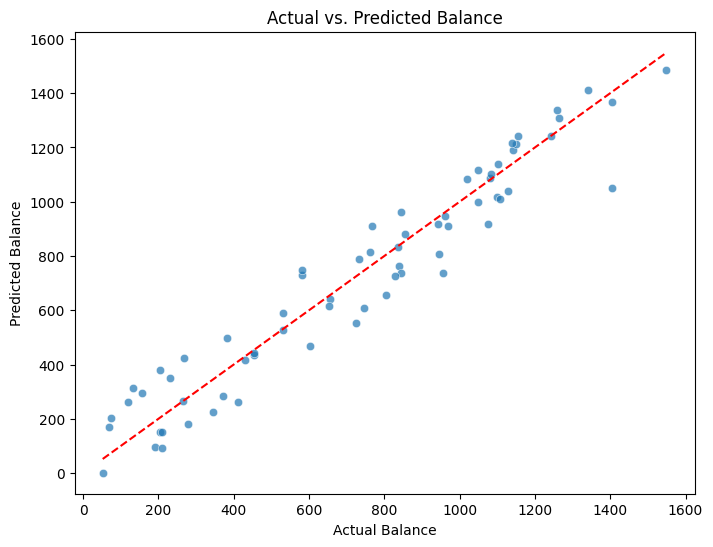

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Konversi DataFrame PySpark ke Pandas
pred_df = predictions.select("Balance", "prediction").toPandas()

# 2️⃣ Scatter Plot: Balance (Actual) vs. Prediction
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_df["Balance"], y=pred_df["prediction"], alpha=0.7)
plt.plot([pred_df["Balance"].min(), pred_df["Balance"].max()], 
         [pred_df["Balance"].min(), pred_df["Balance"].max()], 
         color="red", linestyle="--")  # Garis referensi y=x
plt.xlabel("Actual Balance")
plt.ylabel("Predicted Balance")
plt.title("Actual vs. Predicted Balance")
plt.show()
